# Spread of Salmollosis in NSW (2008-2016)

### Kiranmayi Vadlamudi 
#### Centre for Complex Systems, University of Sydney

The methodologies and approach used in the notebook could be used as a potential digonistic tool for the analysis and exploration of any communicable disease. This notebook particularly explores the spread of Salmonella Typhirium in New South Wales, Australia between the period of 2008-2016. The data was made available in collaboration with the Westmead Hospital and Charles Perkins Centre University of Sydney. The modelling and network study of the disease spread was made possible due to Centre for Complex Systems at University of Sydnney.<br>
This notebook was the starting point of the data exploration and study that was adapted and implemented in MATLAB which led to the final results and findings published here - https://www.nature.com/articles/s41598-019-42582-3. 

Importing modules

In [1]:
%%time
# basic stuff
import os
import pandas as pd
import numpy as np
from random import randint, uniform
import datetime 

# geo stuff
import geopandas as gp
import shapely
from shapely.geometry import Point
# from ipyleaflet import (Map,
#     Marker,
#     TileLayer, ImageOverlay,
#     Polyline, Polygon, Rectangle, Circle, CircleMarker,
#     GeoJSON,
#     DrawControl
# )

# plotting stuff
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('bmh')
plt.rcParams['figure.figsize'] = (10.0, 10.0)

# widget stuff
from ipywidgets import interact, HTML, FloatSlider
from IPython.display import clear_output, display

# progress stuff
#from tqdm import tqdm_notebook, tqdm_pandas

# turn warnings off
import warnings
warnings.filterwarnings('ignore')

CPU times: user 1.24 s, sys: 466 ms, total: 1.71 s
Wall time: 2.14 s


### About the Data

The data was collected from patients who reported cases of food posioning and were tested got tested. 
The date, coordinates of the patients reported sickeness along with the isolated bacterial DNA sequence characterised by a unique MLVA (multiple-locus variable-number tandem-repeats analysis) was provided in the dataset. A “tandem-repeat” is defined as a pattern of several nucleotides which is repeated and the repetitions
are directly adjacent to each other. The MLVA profile is defined as a string of integers representing the numbers of repeats in several fixed genetic locations (loci), e.g., 3-9-7-12-523. Thus, MLVA profiles consist of the total numbers of tandem repeats in each of five loci. To read more about MLVA refer to the [original paper]( https://www.nature.com/articles/s41598-019-42582-3).

In [2]:
pd.read_csv("/Volumes/harddisk/kiran usb_backup/project_job/dataset_mod/location_all.csv").head()

,date,X,Y,MLVA
0,1/1/08,147.836489,-33.115304,3-11-10-8-523
1,1/2/08,150.845073,-33.796087,3-12-12-11-523
2,1/2/08,149.763689,-34.680625,3-12-12-11-523
3,1/2/08,151.397088,-33.481012,4-13-10-0-490
4,1/2/08,145.866300,-34.595623,4-16-9-0-517


Each row in the data corresponds to an individual reported case. 

date - date of the case reported<br>
X, Y - coordinates of the case<br>
MLVA - unique identifier<br>


In [55]:
dataset = pd.read_csv("/Volumes/harddisk/kiran usb_backup/project_job/dataset_mod/location_all.csv")

In [4]:
#dimension of the dataset
dataset.shape

(16860, 4)

In [100]:
#checking for number of occurences each MLVA type 
display(dataset['MLVA'].value_counts()[0:60])

#number of unique MLVA types in the dataset
display(len(set(dataset['MLVA'])))

3-9-7-13-523      1439
3-9-8-12-523       626
3-9-7-12-523       573
3-9-8-13-523       540
3-17-9-11-523      428
3-10-8-9-523       381
3-17-9-12-523      377
3-9-7-14-523       366
3-12-12-9-523      355
3-12-9-10-550      336
3-12-11-14-523     334
3-26-13-8-523      274
3-10-14-12-496     240
3-10-14-11-496     222
3-16-9-11-523      172
3-9-7-15-523       170
3-24-13-10-523     161
3-13-11-9-523      160
3-16-9-12-523      159
3-10-7-12-523      155
3-12-15-13-523     142
3-17-10-11-523     122
3-9-9-12-523       119
4-15-11-0-490      116
3-10-7-13-523      111
3-10-8-12-523      104
3-12-13-9-523      100
3-9-9-13-523        99
3-14-11-12-523      94
3-10-15-12-496      93
3-9-8-14-523        88
3-10-13-11-496      85
3-12-9-12-523       78
3-12-9-13-523       75
3-10-7-14-523       74
3-17-16-13-523      72
3-12-9-11-550       68
3-18-9-11-523       68
3-10-15-11-496      67
3-10-13-12-496      67
3-12-10-12-523      66
3-10-7-15-523       64
3-9-8-9-523         64
3-13-10-11-

1671

Based on this it looks like some MLVA types are more common than others. I am not going to try and plot the distribution but an approximate and reasonable guess would be that it follows some form of a power law function.<br>
However it seems like the most common MLVA type "3-9-7-13-523" does occur 1439 times in the dataset. It would be interesting to see what its spatial distribution is like and if we can find any patterns. 

### Visualisation of the most common MLVA  type

In [6]:
#Filtering the dataset with the most common occuring MLVA
common_seq =dataset[dataset.MLVA.eq("3-9-7-13-523")]

In [7]:
#checking to see the type of date column
type(common_seq.date)

pandas.core.series.Series

In [8]:
#converting the x,y cordinates into point geometry
common_seq['geometry'] = common_seq.apply(lambda z: Point(z.X, z.Y), axis=1)

#converting the dataframe into a spatial dataframe using geopandas
common_seq = gp.GeoDataFrame(common_seq)

#turning the date column to pandas datetime columns
common_seq.date=pd.to_datetime(common_seq.date)

In [9]:
common_seq.head()

,date,X,Y,MLVA,geometry
218,2008-03-04,150.999875,-33.727899,3-9-7-13-523,POINT (150.999875 -33.727899)
359,2008-03-31,152.931134,-27.727051,3-9-7-13-523,POINT (152.931134 -27.727051)
554,2008-05-08,151.135607,-33.994508,3-9-7-13-523,POINT (151.135607 -33.994508)
596,2008-05-20,151.236984,-33.942397,3-9-7-13-523,POINT (151.236984 -33.942397)
600,2008-05-21,151.524834,-33.253516,3-9-7-13-523,POINT (151.524834 -33.253516)


I am going to start with trying to look for spatial patterns, ignoring the date column for now. I will start by simply plotting the points on the boundary shapefile of australia using matplotlib followed by contextilly.

**Matplotlib & Geopandas**

In [10]:
%%time
%matplotlib inline
#shp = gp.read_file('/media/madhav/057A-C8FC/project_job/dataset_mod/shapefile_au/POA_2016_AUST.shp')
shp = gp.read_file('/Volumes/harddisk/kiran usb_backup/project_job/australia/POA_2016_AUST.shp')

CPU times: user 2.05 s, sys: 173 ms, total: 2.22 s
Wall time: 2.45 s


CPU times: user 5.82 s, sys: 184 ms, total: 6 s
Wall time: 6.34 s


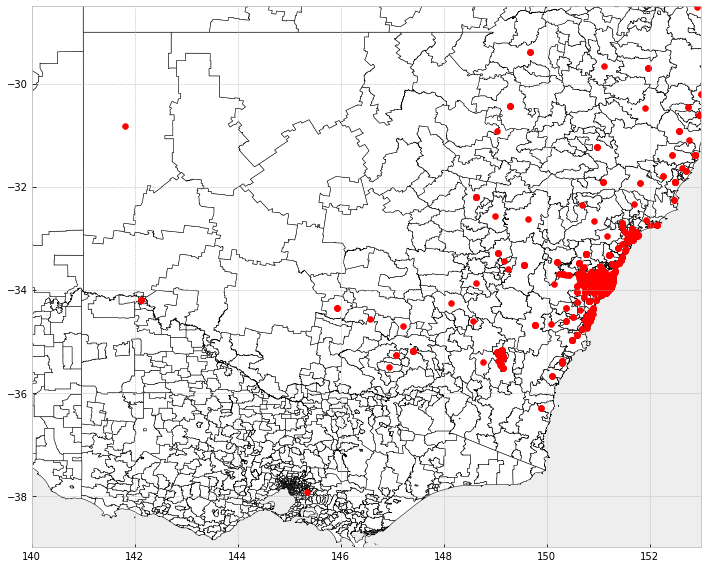

In [11]:
%%time
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 12))
ax.set_aspect('equal')
shp.plot(ax=ax, color='white', edgecolor='black')
ax.set_xlim([140, 153])
ax.set_ylim([-39, -28.5])
#location.plot(ax=base, marker='o', color='red', markersize=8);
plt.scatter(x=common_seq.X, y=common_seq.Y,marker='o', color='red')

This shows, that most of the cases of this cluster seme to be concentrated in Sydney but some parts of regional NSW as well. There is one case in Melbourne as well. Since I want to try and know more about whats really happenign with this cluster, I am going to try and do a few visual/plotting experiements. 

Lets see if there is any pattern occuring if I group the occurences of this MLVA type by year.

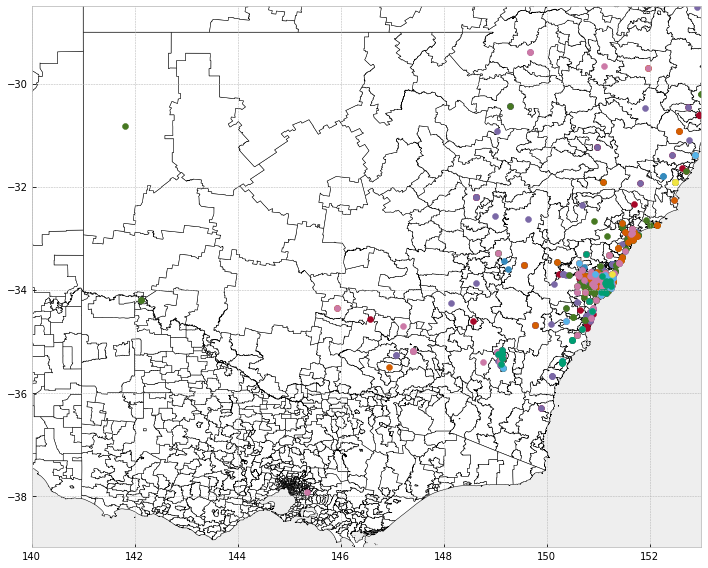

In [12]:
xlocate = common_seq.groupby(common_seq.date.dt.year)
fig= plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
ax.set_xlim([140, 153])
ax.set_ylim([-39, -28.5])
base=shp.plot(ax=ax, color='white', edgecolor='black')
xlocate.plot(ax = base)
#ax.scatter(location.X, location.Y, color = 'red')
plt.show()

**Matplotlib, Contextilly & Geopandas**

In [13]:
import contextily as ctx

In [14]:
#checking for crs
display(type(common_seq))
display(common_seq.crs)

geopandas.geodataframe.GeoDataFrame

None

Even though I converted common_seq into a geodataframe, I didnt set a projection to it. But to plot using contextily, I would need to give the geometry of the spatial dataframe a projection. I am going to try and convert the projection to the one I need and see what happens.

In [15]:
common_seq_prj = common_seq.to_crs(epsg=3857)

ValueError: Cannot transform naive geometries.  Please set a crs on the object first.

Now its interesting to see even though common_seq is a geodataframe its not accepting a projection conversion. This is because an initial projection wasn't set when the geodataframe was made. So am going to filter the data again and assign a coordinate reference system(crs).

In [16]:
d = dataset[dataset.MLVA.eq("3-9-7-13-523")]
common_seq_prj = gp.GeoDataFrame(d,
                               crs= {'init': 'epsg:3857'}, 
                               geometry=gp.points_from_xy(d.X, d.Y))

In [17]:
display(common_seq_prj.head())
display(common_seq_prj.crs)

,date,X,Y,MLVA,geometry
218,3/4/08,150.999875,-33.727899,3-9-7-13-523,POINT (150.999875 -33.727899)
359,3/31/08,152.931134,-27.727051,3-9-7-13-523,POINT (152.931134 -27.727051)
554,5/8/08,151.135607,-33.994508,3-9-7-13-523,POINT (151.135607 -33.994508)
596,5/20/08,151.236984,-33.942397,3-9-7-13-523,POINT (151.236984 -33.942397)
600,5/21/08,151.524834,-33.253516,3-9-7-13-523,POINT (151.524834 -33.253516)


{'init': 'epsg:3857'}

Lets plot and see if this works. I am going to use the stamen toner background to plot the points.

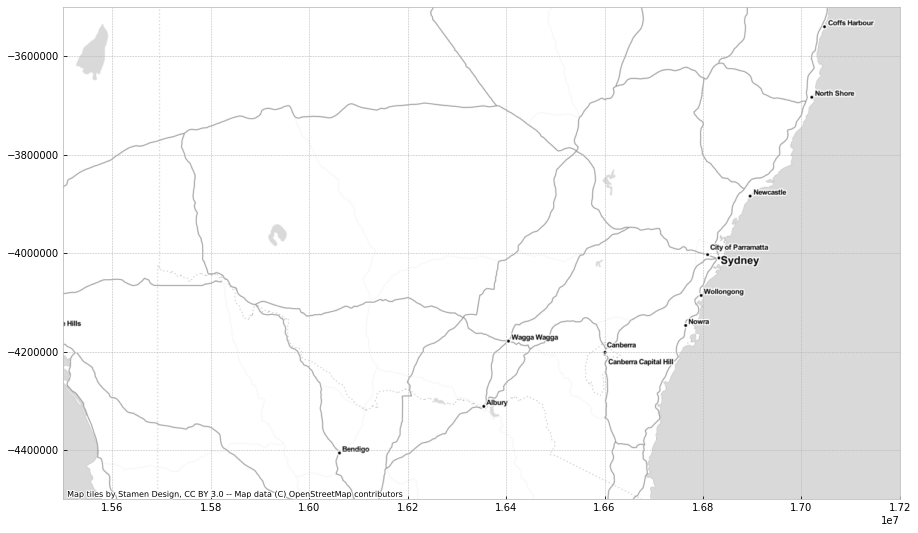

In [18]:
ax = common_seq_prj.plot(figsize=(15, 15), marker='o', color='red', markersize=5);
ax.set_xlim(15500000, 17200000)
ax.set_ylim(-4500000, -3500000)
ctx.add_basemap(ax, url=ctx.providers.Stamen.TonerLite)

For some reason the points haven't been plotted despite setting the projection. There are two reasons this could happen: <br>
* There is a mismatch between the projection of the underlying web map tiles.
* assigning the projection isn't the same as projecting the coordinate reference systems.

As it happens the web map tiles usualy have <a href="url" target="https://geopandas.org/gallery/plotting_basemap_background.html"> web mercator projection (EPSG 3857) </a>.  <br>
Since the first is ruled out, it would mean that our assigned projection hasnt actually been projected. We can check this by having a look at the geometry column of the daatset. 

In [19]:
 (common_seq_prj.head())

,date,X,Y,MLVA,geometry
218,3/4/08,150.999875,-33.727899,3-9-7-13-523,POINT (150.999875 -33.727899)
359,3/31/08,152.931134,-27.727051,3-9-7-13-523,POINT (152.931134 -27.727051)
554,5/8/08,151.135607,-33.994508,3-9-7-13-523,POINT (151.135607 -33.994508)
596,5/20/08,151.236984,-33.942397,3-9-7-13-523,POINT (151.236984 -33.942397)
600,5/21/08,151.524834,-33.253516,3-9-7-13-523,POINT (151.524834 -33.253516)


The point coordinate has x, y in non projected coordinate system at ~ 150 and -33, however the map displayed above has projected x axis in order of $10^7$. 

In [20]:
d = dataset[dataset.MLVA.eq("3-9-7-13-523")]
common_seq_prj = gp.GeoDataFrame(d,
                               crs= {'init': 'epsg:4283'}, 
                               geometry=gp.points_from_xy(d.X, d.Y))
common_seq_prj = common_seq_prj.to_crs(epsg=3857)

In [21]:
display(common_seq_prj.head()) #the geometry column now shows projected coordinates
display(common_seq_prj.crs)

,date,X,Y,MLVA,geometry
218,3/4/08,150.999875,-33.727899,3-9-7-13-523,POINT (16809229.19484796 -3992323.766749803)
359,3/31/08,152.931134,-27.727051,3-9-7-13-523,POINT (17024215.96331789 -3214604.545643983)
554,5/8/08,151.135607,-33.994508,3-9-7-13-523,POINT (16824338.81197231 -4028064.608553088)
596,5/20/08,151.236984,-33.942397,3-9-7-13-523,POINT (16835624.04799046 -4021069.970654134)
600,5/21/08,151.524834,-33.253516,3-9-7-13-523,POINT (16867667.3634153 -3929002.520658786)


{'init': 'epsg:3857', 'no_defs': True}

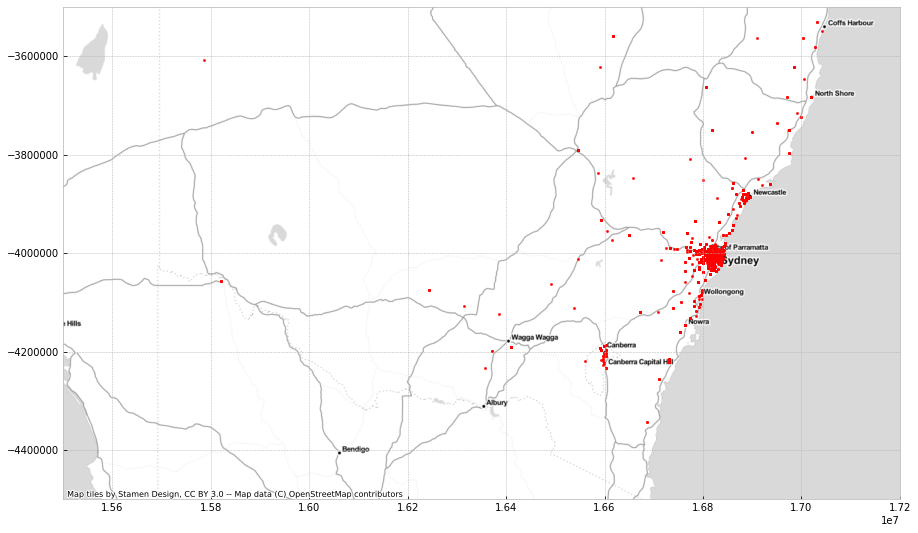

In [22]:
ax = common_seq_prj.plot(figsize=(15, 15), marker='o', color='red', markersize=5);
ax.set_xlim(15500000, 17200000)
ax.set_ylim(-4500000, -3500000)
ctx.add_basemap(ax, url=ctx.providers.Stamen.TonerLite)

In [23]:
common_seq_prj.date=pd.to_datetime(common_seq_prj.date)
display(type(common_seq_prj.date))

pandas.core.series.Series

In [24]:
xlocate = common_seq_prj.groupby(common_seq_prj.date.dt.year)

In [25]:
years_list = list()
for key, values in xlocate:
    years_list.append(values)
    print(key)

2008
2009
2010
2011
2012
2013
2014
2015
2016


In [26]:
for i in range(len(years_list)):
    years_list[i] = years_list[i].to_crs(epsg=3857)

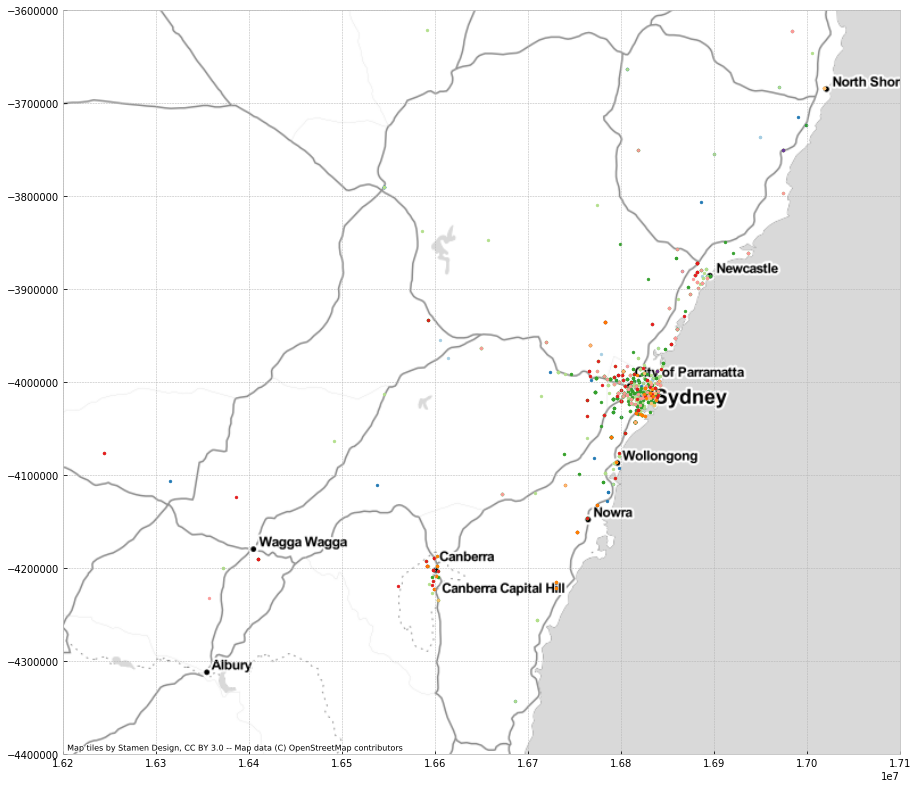

In [27]:
#fig3, ax3 = plt.subplots(1)
ax3 =  years_list[0].plot(figsize=(15, 15), marker='o',color = '#a6cee3', markersize=8);
years_list[1].plot(ax = ax3, marker='o',color = '#1f78b4', markersize=8);
years_list[2].plot(ax = ax3, marker='o',color = '#b2df8a', markersize=8);
years_list[3].plot(ax = ax3, marker='o',color = '#33a02c', markersize=8);
years_list[4].plot(ax = ax3, marker='o',color = '#fb9a99', markersize=8);
years_list[5].plot(ax = ax3, marker='o',color = '#e31a1c', markersize=8);
years_list[6].plot(ax = ax3, marker='o',color = '#fdbf6f', markersize=8);
years_list[7].plot(ax = ax3, marker='o',color = '#ff7f00', markersize=8);
years_list[8].plot(ax = ax3, marker='o',color = '#6a3d9a', markersize=8);
ax3.set_xlim(16200000, 17100000)
ax3.set_ylim(-4400000, -3600000)
ctx.add_basemap(ax3, url=ctx.providers.Stamen.TonerLite)

Despite the nice looking map and being able to use web tiles for background, its very hard to tell the spatial patterns. <br>
The many overlapping points/cases around Sydney grouped by year and using different colurs doesnt really help in seeing any spatial patterns of the disease spread unfortunately.
Since the spatial patterns are so connected with the date of occurence, it might be helpful to include date/temporal component into the visualisation and see if its possible to track the spatial spread over time.

### Interactive Visualisation

In order to incorporate the time dimension into the visualisatio, I start out with making an interactive visualisation using Ipywidgets. 

**Ipywidgets**

In [28]:
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

I decide to try out a few different types of widgets. Starting with a box type, where you can input the date and it pulls up the point from the geodataframe.

In [29]:
%%time
def make_plot(date):

    # filter dataframe
    temp=common_seq_prj[common_seq_prj.date==date]

    # plot
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.set_aspect('equal')
    shp.plot(ax=ax, color='white', edgecolor='black')
    ax.set_xlim([140, 153])
    ax.set_ylim([-39, -28.5])
    plt.scatter(x=temp.X, y=temp.Y,marker='o', color='red')
    plt.show()
    #hulls.plot(ax=gdf.plot())
    #plt.scatter(x=temp['x'], y=temp['y'], s=30)
    
# create widget
interact(make_plot, date ='2008-03-31')

interactive(children=(Text(value='2008-03-31', description='date'), Output()), _dom_classes=('widget-interact'…

CPU times: user 9.24 s, sys: 427 ms, total: 9.67 s
Wall time: 9.8 s


This only brings up one point/case on the map at a time and seems to also be very time consuming. I havent been able to figure out why this is so. I would guess it might be because filtering for that one row out of ~16k rows is time consuming.
In any case, its not very useful for our case since its so hard to keep track of how the cases are evolving. <br>
Next I decide to try a slider for different time granularities - year and date. 

In [30]:
%%time 
year_slider= widgets.SelectionSlider(
    options=[(i) for i in np.unique(common_seq_prj.date.dt.year)],
    description='year',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True
    )

date_slider = widgets.SelectionSlider(
    options=[(i) for i in common_seq_prj.date],
    description='date',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True
    )

CPU times: user 63.5 ms, sys: 5.47 ms, total: 69 ms
Wall time: 78.5 ms


In [31]:
@interact(date = date_slider)

def make_plot(date):
    temp=common_seq_prj[common_seq_prj.date==date]
    # plot
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.set_aspect('equal')
    shp.plot(ax=ax, color='white', edgecolor='black')
    ax.set_xlim([140, 153])
    ax.set_ylim([-39, -28.5])
    plt.scatter(x=temp.X, y=temp.Y,marker='o', color='red')
    plt.show()

interactive(children=(SelectionSlider(continuous_update=False, description='date', options=(Timestamp('2008-03…

The date slider is a bit faster than having to input the date and filter the dataset to 

In [32]:
@interact(year = year_slider)
def make_plot(year):
    temp=common_seq_prj[common_seq_prj.date.dt.year==year]
    fig= plt.figure(figsize=(12,12))
    ax = fig.add_subplot(111)
    ax.set_xlim([142, 153])
    ax.set_ylim([-39, -28.5])
    base=shp.plot(ax=ax, color='white', edgecolor='black')
    common_seq_prj.plot(ax = base)

    #shp.plot(ax=ax, color='white', edgecolor='black')

    ax.scatter(x=temp.X, y=temp.Y,marker='o', color='red')
    #location.plot(ax=base, color='red', markersize=5);
    plt.show()

interactive(children=(SelectionSlider(continuous_update=False, description='year', options=(2008, 2009, 2010, …

The year slider is much better visualisation. However it still doesnt give the granularity I wish to have to track the cases. Given the density of cases around Sydney its hard to tell any patterns apart.

**Bokeh**

In [80]:
from bokeh.layouts import column
from bokeh.layouts import widgetbox
from bokeh.models import CustomJS, ColumnDataSource, Slider
from bokeh.plotting import Figure, output_file, show, save
import geopandas as gp
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from bokeh.plotting import figure, output_file, show
from bokeh.tile_providers import get_provider, Vendors
from bokeh.models import ColumnDataSource, CategoricalColorMapper
from bokeh.models import HoverTool
from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook, push_notebook

In [34]:
common_seq_prj=common_seq_prj.sort_values('date')
common_seq_prj['month'] = pd.Series(common_seq_prj.date.dt.month, index = common_seq_prj.index)
common_seq_prj['year'] = pd.Series(common_seq_prj.date.dt.year, index = common_seq_prj.index)
common_seq_prj.set_index(['year', 'month'], inplace=True)
display(common_seq_prj.head())
display(type(common_seq_prj))

date           X          Y          MLVA  \
year month                                                   
2008 3     2008-03-04  150.999875 -33.727899  3-9-7-13-523   
     3     2008-03-31  152.931134 -27.727051  3-9-7-13-523   
     5     2008-05-08  151.135607 -33.994508  3-9-7-13-523   
     5     2008-05-20  151.236984 -33.942397  3-9-7-13-523   
     5     2008-05-21  151.524834 -33.253516  3-9-7-13-523   

                                                geometry  
year month                                                
2008 3      POINT (16809229.19484796 -3992323.766749803)  
     3      POINT (17024215.96331789 -3214604.545643983)  
     5      POINT (16824338.81197231 -4028064.608553088)  
     5      POINT (16835624.04799046 -4021069.970654134)  
     5       POINT (16867667.3634153 -3929002.520658786)

geopandas.geodataframe.GeoDataFrame

In [35]:
def getXYCoords(geometry, coord_type):
    """ Returns either x or y coordinates from  geometry coordinate sequence. Used with LineString and Polygon geometries."""
    if coord_type == 'x':
        return geometry.coords.xy[0]
    elif coord_type == 'y':
        return geometry.coords.xy[1]

def getPolyCoords(geometry, coord_type):
    """ Returns Coordinates of Polygon using the Exterior of the Polygon."""
    ext = geometry.exterior
    return getXYCoords(ext, coord_type)

def getLineCoords(geometry, coord_type):
    """ Returns Coordinates of Linestring object."""
    return getXYCoords(geometry, coord_type)

def getPointCoords(geometry, coord_type):
    """ Returns Coordinates of Point object."""
    if coord_type == 'x':
        return geometry.x
    elif coord_type == 'y':
        return geometry.y

def multiGeomHandler(multi_geometry, coord_type, geom_type):
    """
    Function for handling multi-geometries. Can be MultiPoint, MultiLineString or MultiPolygon.
    Returns a list of coordinates where all parts of Multi-geometries are merged into a single list.
    Individual geometries are separated with np.nan which is how Bokeh wants them.
    # Bokeh documentation regarding the Multi-geometry issues can be found here (it is an open issue)
    # https://github.com/bokeh/bokeh/issues/2321
    """

    for i, part in enumerate(multi_geometry):
        # On the first part of the Multi-geometry initialize the coord_array (np.array)
        if i == 0:
            if geom_type == "MultiPoint":
                coord_arrays = np.append(getPointCoords(part, coord_type), np.nan)
            elif geom_type == "MultiLineString":
                coord_arrays = np.append(getLineCoords(part, coord_type), np.nan)
            elif geom_type == "MultiPolygon":
                coord_arrays = np.append(getPolyCoords(part, coord_type), np.nan)
        else:
            if geom_type == "MultiPoint":
                coord_arrays = np.concatenate([coord_arrays, np.append(getPointCoords(part, coord_type), np.nan)])
            elif geom_type == "MultiLineString":
                coord_arrays = np.concatenate([coord_arrays, np.append(getLineCoords(part, coord_type), np.nan)])
            elif geom_type == "MultiPolygon":
                coord_arrays = np.concatenate([coord_arrays, np.append(getPolyCoords(part, coord_type), np.nan)])

    # Return the coordinates
    return coord_arrays


def getCoords(row, geom_col, coord_type):
    """
    Returns coordinates ('x' or 'y') of a geometry (Point, LineString or Polygon) as a list (if geometry is LineString or Polygon).
    Can handle also MultiGeometries.
    """
    # Get geometry
    geom = row[geom_col]

    # Check the geometry type
    gtype = geom.geom_type

    # "Normal" geometries
    # -------------------

    if gtype == "Point":
        return getPointCoords(geom, coord_type)
    elif gtype == "LineString":
        return list( getLineCoords(geom, coord_type) )
    elif gtype == "Polygon":
        return list( getPolyCoords(geom, coord_type) )

    # Multi geometries
    # ----------------

    else:
        return list( multiGeomHandler(geom, coord_type, gtype) )

In [36]:
common_seq_prj['geom_x'] = common_seq_prj.apply(getCoords, geom_col="geometry", coord_type="x", axis=1)
common_seq_prj['geom_y'] = common_seq_prj.apply(getCoords, geom_col="geometry", coord_type="y", axis=1)

In [37]:
display(common_seq_prj.head())
#display(type(all_mlva_layer)

date           X          Y          MLVA  \
year month                                                   
2008 3     2008-03-04  150.999875 -33.727899  3-9-7-13-523   
     3     2008-03-31  152.931134 -27.727051  3-9-7-13-523   
     5     2008-05-08  151.135607 -33.994508  3-9-7-13-523   
     5     2008-05-20  151.236984 -33.942397  3-9-7-13-523   
     5     2008-05-21  151.524834 -33.253516  3-9-7-13-523   

                                                geometry        geom_x  \
year month                                                               
2008 3      POINT (16809229.19484796 -3992323.766749803)  1.680923e+07   
     3      POINT (17024215.96331789 -3214604.545643983)  1.702422e+07   
     5      POINT (16824338.81197231 -4028064.608553088)  1.682434e+07   
     5      POINT (16835624.04799046 -4021069.970654134)  1.683562e+07   
     5       POINT (16867667.3634153 -3929002.520658786)  1.686767e+07   

                  geom_y  
year month                
2008 3     -3.992324e+06  
     3     -3.214605e+06  
     5     -4.028065e+06  
     5     -4.021070e+06  
     5     -3.929003e+06

In [38]:
def update_2(year, month):
    new_data= dict(
    lng=common_seq_prj.loc[year].loc[month].geom_y,
    lat= common_seq_prj.loc[year].loc[month].geom_x,
    MLVA = common_seq_prj.loc[year].loc[month].MLVA,
    date =  common_seq_prj.loc[year].loc[month].date.dt.day
    )
    source.data=new_data
    push_notebook()
    
tile_provider = get_provider(Vendors.STAMEN_TONER)
source = ColumnDataSource(dict(
    lat = common_seq_prj['geom_x'],
    lng = common_seq_prj['geom_y'] ,
    mlva = common_seq_prj['MLVA'], 
    date = common_seq_prj['date']
)
                         )

TOOLTIPS = [
   #('MLVA','@mlva'), 
    ('date','@date') 
]                                                       


# range bounds supplied in web mercator coordinates
p = figure(x_range=(15500000, 17200000), y_range=(-4500000, -3500000),
           x_axis_type="mercator", y_axis_type="mercator",
           tooltips=TOOLTIPS
          )

p.add_tile(tile_provider)


p.circle("lat","lng", size = 10, 
         source = source, 
         #fill_color = {'field':'color', 'transform': color_mapper}, 
         fill_alpha=1, 
         line_color=None
        )
output_file("mostcommonMLVA.html")
output_notebook()
show(p, notebook_handle=True)

Loading BokehJS ...

In [39]:
interact(update_2,year=(2008,2016,1), month = (1,12,1))

interactive(children=(IntSlider(value=2012, description='year', max=2016, min=2008), IntSlider(value=6, descri…

<function __main__.update_2(year, month)>

This type of interactive visualisation gives more of an insight into how the spread of the most common MLVA is occuring over the span of 8 years. However it is very likely the most common strain could have evolved over the span of 8 years into other strains that are more virulent or able to stay around longer in the population. In order to test how this evolution between the strains could have happened, we make an assumption that all strains with the same last number belong to a cluster. We do know mutations in the  - point process (write this more)<br>

Frequency based group split


In [92]:
red = ['3-9-7-13-523','3-9-8-12-523','3-9-7-12-523','3-9-8-13-523','3-17-9-11-523']

orange = ['3-10-8-9-523','3-17-9-12-523','3-9-7-14-523','3-12-12-9-523',
          '3-12-11-14-523','3-12-9-10-550','3-26-13-8-523','3-10-14-12-496',
          '3-10-14-11-496','3-16-9-11-523','3-9-7-15-523','3-24-13-10-523',
          '3-13-11-9-523','3-16-9-12-523','3-10-7-12-523','3-12-15-13-523',
          '3-17-10-11-523','3-9-9-12-523']

blue = ['4-15-11-0-490','3-10-7-13-523',
        '3-10-8-12-523','3-9-9-13-523',
        '3-12-13-9-523','3-14-11-12-523',
        '3-10-15-12-496','3-9-8-14-523',
        '3-10-13-11-496','3-12-9-12-523',
        '3-10-7-14-523','3-12-9-13-523',
        '3-17-16-13-523','3-12-9-11-550',
        '3-18-9-11-523','3-10-13-12-496',
        '3-10-15-11-496','3-10-7-15-523',
        '3-12-10-12-523','3-13-10-11-523',
        '3-9-8-9-523','3-25-18-12-523',
        '4-15-12-0-490','3-23-23-11-523',
        '4-15-10-0-490','3-17-8-11-523',
        '3-11-10-8-523','3-25-13-10-523',
        '3-24-14-10-523','4-13-10-0-490',
        '3-10-8-10-523','3-13-12-9-523',
        '3-9-8-11-523']
combined = red + orange + blue

In [93]:
dataset = pd.read_csv("/Volumes/harddisk/kiran usb_backup/project_job/dataset_mod/location_all.csv")
dataset.date = pd.to_datetime(dataset.date)

In [94]:
# converting dataset to a geopandas dataframe
dataset_prj = gp.GeoDataFrame(dataset, crs= {'init': 'epsg:4283'},
                              geometry=gp.points_from_xy(dataset.X, dataset.Y))
dataset_prj = dataset_prj.to_crs(epsg=3857)
dataset_prj['geom_x'] = dataset_prj.apply(getCoords, geom_col="geometry", coord_type="x", axis=1)
dataset_prj['geom_y'] = dataset_prj.apply(getCoords, geom_col="geometry", coord_type="y", axis=1)

#listing all MLVA
allm= list(dataset.MLVA)

#making a list purple which has all MLVA other than the ones listed in red, orange and blue
purple = list(np.setdiff1d(allm, combined))


#adding date and month index to whole dataset
dataset_prj.date = pd.to_datetime(dataset_prj.date)
dataset_prj=dataset_prj.sort_values('date')
dataset_prj['month'] = pd.Series(dataset_prj.date.dt.month, index = dataset_prj.index)
dataset_prj['year'] = pd.Series(dataset_prj.date.dt.year, index = dataset_prj.index)
dataset_prj.set_index(['year', 'month'], inplace=True)



#adding a colur column to the dataset based on the MLVA categorisation we did above
dataset_prj.loc[dataset_prj['MLVA'].isin(blue), 'color'] = 'blue'
dataset_prj.loc[dataset_prj['MLVA'].isin(orange), 'color'] = 'orange'
dataset_prj.loc[dataset_prj['MLVA'].isin(red), 'color'] = 'red'
dataset_prj.loc[dataset_prj['MLVA'].isin(purple), 'color'] = 'purple'
display(dataset_prj.head())

date           X          Y            MLVA  \
year month                                                     
2008 1     2008-01-01  147.836489 -33.115304   3-11-10-8-523   
     1     2008-01-02  150.845073 -33.796087  3-12-12-11-523   
     1     2008-01-02  149.763689 -34.680625  3-12-12-11-523   
     1     2008-01-02  151.397088 -33.481012   4-13-10-0-490   
     1     2008-01-02  145.866300 -34.595623    4-16-9-0-517   

                                                geometry        geom_x  \
year month                                                               
2008 1      POINT (16457082.67614539 -3910618.660723946)  1.645708e+07   
     1      POINT (16791996.71503418 -4001454.246238604)  1.679200e+07   
     1      POINT (16671617.59880219 -4120563.613719278)  1.667162e+07   
     1      POINT (16853446.74374443 -3959325.694513463)  1.685345e+07   
     1      POINT (16237762.23989888 -4109062.811494758)  1.623776e+07   

                  geom_y   color  
year month                        
2008 1     -3.910619e+06    blue  
     1     -4.001454e+06  purple  
     1     -4.120564e+06  purple  
     1     -3.959326e+06    blue  
     1     -4.109063e+06  purple

In [97]:
def update(year, month):
    new_data= dict(
    lng=dataset_prj.loc[year].loc[month].geom_y,
    lat= dataset_prj.loc[year].loc[month].geom_x,
    MLVA = dataset_prj.loc[year].loc[month].MLVA,
    color=dataset_prj.loc[year].loc[month].color,
    date =  dataset_prj.loc[year].loc[month].date.dt.day
    )
    source.data=new_data
    push_notebook()
    
tile_provider = get_provider(Vendors.STAMEN_TONER)

source = ColumnDataSource(dict(
    lat = dataset_prj['geom_x'],
    lng = dataset_prj['geom_y'] ,
    color = dataset_prj['color'],
    mlva = dataset_prj['MLVA'], 
    date = dataset_prj['date']
)
                         )

my_palette = ['#f03b20', '#fd8d3c', '#2b8cbe', '#9e9ac8']
color_mapper = CategoricalColorMapper(factors = ['red', 'orange', 'blue', 'purple'], palette = my_palette)

TOOLTIPS = [
   ('MLVA','@mlva'), 
    ('date','@date') 
]                                                       


# range bounds supplied in web mercator coordinates
p = figure(x_range=(15500000, 17200000), y_range=(-4500000, -3500000),
           x_axis_type="mercator", y_axis_type="mercator",
           tooltips=TOOLTIPS
          )
p.add_tile(tile_provider)
p.circle("lat","lng", size = 10, 
         source = source, 
         fill_color = {'field':'color', 'transform': color_mapper}, 
         fill_alpha=1, 
         line_color=None
        )

output_notebook()
show(p, notebook_handle=True)

Loading BokehJS ...

In [98]:
interact(update,year=(2008,2016,1), month = (1,12,1))

interactive(children=(IntSlider(value=2012, description='year', max=2016, min=2008), IntSlider(value=6, descri…

<function __main__.update(year, month)>

### Measuring Distance between the MLVA type

In [ ]:
#what are we doing here -?

In [101]:
#reading in all unique mlva
mlvau = pd.read_csv('/Volumes/harddisk/kiran usb_backup/project_job/dataset_mod/mlva_u.csv')

explain the function below here.

In [ ]:
#findings all MLVA within a distance of 10 from the MLVA of interest
newd = [0]* len(mlvau)
k = 1054
d = []
f = []
e = open('trial.txt','w')
g= []
for i in range(len(mlvau)):
    d = (abs(mlvau.loc[k][0]-mlvau.loc[i][0]) + abs(mlvau.loc[k][1]-mlvau.loc[i][1]) + abs(mlvau.loc[k][2]-mlvau.loc[i][2]) + abs(mlvau.loc[k][3]-mlvau.loc[i][3]) + abs(mlvau.loc[k][4]-mlvau.loc[i][4]))
    if d <= 10:
        f.append(d)
        e.write("%s\n" %mlvau.loc[i]) 
        g.append(mlvau.loc[i])
e.close()

In [110]:
with open('/Volumes/harddisk/kiran usb_backup/project_job/dataset_mod/z.txt') as f:
    z = f.read().splitlines()

In [111]:
lines

['3-12-12-9-523',
 '3-10-10-11-523',
 '3-10-10-12-523',
 '3-10-10-13-523',
 '3-10-10-8-523',
 '3-10-10-9-523',
 '3-10-12-11-523',
 '3-10-13-9-523',
 '3-10-14-9-523',
 '3-10-6-11-523',
 '3-10-6-12-523',
 '3-10-6-13-523',
 '3-10-6-7-523',
 '3-10-7-10-523',
 '3-10-7-11-523',
 '3-10-7-12-523',
 '3-10-7-13-523',
 '3-10-7-14-523',
 '3-10-7-9-523',
 '3-10-8-10-523',
 '3-10-8-12-523',
 '3-10-8-13-523',
 '3-10-8-14-523',
 '3-10-8-15-523',
 '3-10-8-8-523',
 '3-10-8-9-523',
 '3-10-9-10-523',
 '3-10-9-11-523',
 '3-10-9-12-523',
 '3-10-9-13-523',
 '3-10-9-14-523',
 '3-10-9-8-523',
 '3-10-9-9-523',
 '3-11-10-10-523',
 '3-11-10-11-523',
 '3-11-10-12-523',
 '3-11-10-8-523',
 '3-11-10-9-523',
 '3-11-11-10-523',
 '3-11-11-8-523',
 '3-11-11-8-523',
 '3-11-11-9-523',
 '3-11-12-10-523',
 '3-11-12-9-523',
 '3-11-13-9-523',
 '3-11-5-10-523',
 '3-11-5-9-523',
 '3-11-6-12-523',
 '3-11-7-10-523',
 '3-11-7-11-523',
 '3-11-7-12-523',
 '3-11-7-13-523',
 '3-11-7-9-523',
 '3-11-8-10-523',
 '3-11-8-11-523',
 '3-11-8-

# Work in Progress